# 사용 패키지

In [ ]:
!pip install catboost
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, StackingRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import warnings
warnings.filterwarnings(action="ignore")
sns.set
plt.rc('font', family='NanumBarunGothic')

# 데이터 로드

In [ ]:
total = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

In [ ]:
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


# 전처리

In [ ]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [ ]:
a,b=enumerate(["A","B"])
print(a,b)

(0, 'A') (1, 'B')


In [ ]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [ ]:
d_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6}

In [ ]:
total['연월일'] = pd.to_datetime(total['연월일'])

In [ ]:
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [ ]:
total

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,681.033,2018,12,31,0
368084,2018-12-31,21,6,669.961,2018,12,31,0
368085,2018-12-31,22,6,657.941,2018,12,31,0
368086,2018-12-31,23,6,610.953,2018,12,31,0


In [ ]:
tt={2013:0,2014:1,2015:2,2016:3,2017:4,2018:5}
total["year"]=total.year.map(tt)

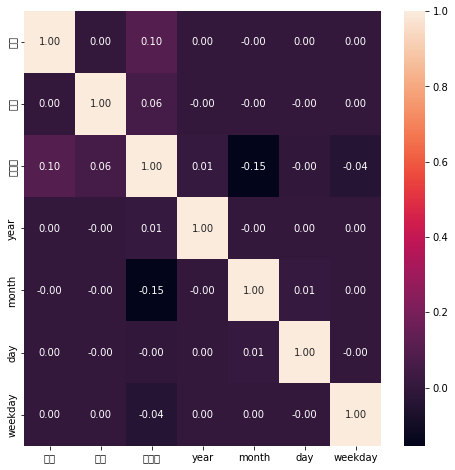

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))     
sns.heatmap(total.corr(), annot=True, fmt=".2f")
plt.show()

# 파생변수

# 주의사항
* 각 업체별 년도별로 공급량의 평균을 확인하기 위해서 각 회사별로 나눴다.
* a_company가 16년도에서 row가 더 많은것이 발견되었다.
* 2016년도 윤년해여서 하루가 더 긴 총 366일을 가지고 있다.

In [ ]:
# a 업체의 평균 공급량
a_company_13 = total[(total.year==0)&(total.구분==0)] # a 업체의 13년도 공급량
a_company_14 = total[(total.year==1)&(total.구분==0)] # a 업체의 14년도 공급량
a_company_15 = total[(total.year==2)&(total.구분==0)] # a 업체의 15년도 공급량
a_company_16 = total[(total.year==3)&(total.구분==0)] # a 업체의 16년도 공급량
a_company_17 = total[(total.year==4)&(total.구분==0)] # a 업체의 17년도 공급량
a_company_18 = total[(total.year==5)&(total.구분==0)] # a 업체의 18년도 공급량
# a_company_mean = total[(total.year==5)&(total.구분==0)] # 평균값을 더해줄 빈 데이터프레임 추가
a_company_total = total[total.구분==0] # a 업체의 전체 공급량

# b 업체의 평균 공급량
b_company_13 = total[(total.year==0)&(total.구분==1)] # b 업체의 13년도 공급량
b_company_14 = total[(total.year==1)&(total.구분==1)] # b 업체의 14년도 공급량
b_company_15 = total[(total.year==2)&(total.구분==1)] # b 업체의 15년도 공급량
b_company_16 = total[(total.year==3)&(total.구분==1)] # b 업체의 16년도 공급량
b_company_17 = total[(total.year==4)&(total.구분==1)] # b 업체의 17년도 공급량
b_company_18 = total[(total.year==5)&(total.구분==1)] # b 업체의 18년도 공급량
# b_company_mean = total[(total.year==5)&(total.구분==1)] # 평균값을 더해줄 빈 데이터프레임 추가
b_company_total = total[total.구분==1] # a 업체의 전체 공급량

# c 업체의 평균 공급량
c_company_13 = total[(total.year==0)&(total.구분==2)] # c 업체의 13년도 공급량
c_company_14 = total[(total.year==1)&(total.구분==2)] # c 업체의 14년도 공급량
c_company_15 = total[(total.year==2)&(total.구분==2)] # c 업체의 15년도 공급량
c_company_16 = total[(total.year==3)&(total.구분==2)] # c 업체의 16년도 공급량
c_company_17 = total[(total.year==4)&(total.구분==2)] # c 업체의 17년도 공급량
c_company_18 = total[(total.year==5)&(total.구분==2)] # c 업체의 18년도 공급량
# c_company_mean = total[(total.year==5)&(total.구분==2)] # 평균값을 더해줄 빈 데이터프레임 추가
c_company_total = total[total.구분==2] # a 업체의 전체 공급량

# d 업체의 평균 공급량
d_company_13 = total[(total.year==0)&(total.구분==3)] # d 업체의 13년도 공급량
d_company_14 = total[(total.year==1)&(total.구분==3)] # d 업체의 14년도 공급량
d_company_15 = total[(total.year==2)&(total.구분==3)] # d 업체의 15년도 공급량
d_company_16 = total[(total.year==3)&(total.구분==3)] # d 업체의 16년도 공급량
d_company_17 = total[(total.year==4)&(total.구분==3)] # d 업체의 17년도 공급량
d_company_18 = total[(total.year==5)&(total.구분==3)] # d 업체의 18년도 공급량
# d_company_mean = total[(total.year==5)&(total.구분==3)] # 평균값을 더해줄 빈 데이터프레임 추가
d_company_total = total[total.구분==3] # a 업체의 전체 공급량

# e 업체의 평균 공급량
e_company_13 = total[(total.year==0)&(total.구분==4)] # d 업체의 13년도 공급량
e_company_14 = total[(total.year==1)&(total.구분==4)] # d 업체의 14년도 공급량
e_company_15 = total[(total.year==2)&(total.구분==4)] # d 업체의 15년도 공급량
e_company_16 = total[(total.year==3)&(total.구분==4)] # d 업체의 16년도 공급량
e_company_17 = total[(total.year==4)&(total.구분==4)] # d 업체의 17년도 공급량
e_company_18 = total[(total.year==5)&(total.구분==4)] # d 업체의 18년도 공급량
# e_company_mean = total[(total.year==5)&(total.구분==4)] # 평균값을 더해줄 빈 데이터프레임 추가
e_company_total = total[total.구분==4] # a 업체의 전체 공급량

# g 업체의 평균 공급량
g_company_13 = total[(total.year==0)&(total.구분==5)] # d 업체의 13년도 공급량
g_company_14 = total[(total.year==1)&(total.구분==5)] # d 업체의 14년도 공급량
g_company_15 = total[(total.year==2)&(total.구분==5)] # d 업체의 15년도 공급량
g_company_16 = total[(total.year==3)&(total.구분==5)] # d 업체의 16년도 공급량
g_company_17 = total[(total.year==4)&(total.구분==5)] # d 업체의 17년도 공급량
g_company_18 = total[(total.year==5)&(total.구분==5)] # d 업체의 18년도 공급량
# g_company_mean = total[(total.year==5)&(total.구분==5)] # 평균값을 더해줄 빈 데이터프레임 추가
g_company_total = total[total.구분==5] # a 업체의 전체 공급량

# h 업체의 평균 공급량
h_company_13 = total[(total.year==0)&(total.구분==6)] # d 업체의 13년도 공급량
h_company_14 = total[(total.year==1)&(total.구분==6)] # d 업체의 14년도 공급량
h_company_15 = total[(total.year==2)&(total.구분==6)] # d 업체의 15년도 공급량
h_company_16 = total[(total.year==3)&(total.구분==6)] # d 업체의 16년도 공급량
h_company_17 = total[(total.year==4)&(total.구분==6)] # d 업체의 17년도 공급량
h_company_18 = total[(total.year==5)&(total.구분==6)] # d 업체의 18년도 공급량
# h_company_mean = total[(total.year==5)&(total.구분==6)] # 평균값을 더해줄 빈 데이터프레임 추가
h_company_total = total[total.구분==6] # a 업체의 전체 공급량

In [ ]:
h_company_16

,연월일,시간,구분,공급량,year,month,day,weekday
236664,2016-01-01,1,6,427.428,3,1,1,4
236665,2016-01-01,2,6,384.252,3,1,1,4
236666,2016-01-01,3,6,341.804,3,1,1,4
236667,2016-01-01,4,6,355.396,3,1,1,4
236668,2016-01-01,5,6,379.644,3,1,1,4
...,...,...,...,...,...,...,...,...
245443,2016-12-31,20,6,531.796,3,12,31,5
245444,2016-12-31,21,6,504.268,3,12,31,5
245445,2016-12-31,22,6,482.476,3,12,31,5
245446,2016-12-31,23,6,450.284,3,12,31,5


In [ ]:
# 2016년도에 2월에 윤달이 껴있어서 하루가 더 많음
a_company_16[["month",'day']].groupby(by=["month","day"]).sum()

Empty DataFrame
Columns: []
Index: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), ...]

[366 rows x 0 columns]

In [ ]:
a_company_13=pd.merge(a_company_13,a_company_14, how="left",on=["month","시간","day","구분"])
a_company_13=pd.merge(a_company_13,a_company_15, how="left",on=["month","시간","day","구분"])
a_company_13=pd.merge(a_company_13,a_company_16, how="left",on=["month","시간","day","구분"])
a_company_13=pd.merge(a_company_13,a_company_17, how="left",on=["month","시간","day","구분"])
a_company_13=pd.merge(a_company_13,a_company_18, how="left",on=["month","시간","day","구분"])
a_company_13

b_company_13=pd.merge(b_company_13,b_company_14, how="left",on=["month","시간","day","구분"])
b_company_13=pd.merge(b_company_13,b_company_15, how="left",on=["month","시간","day","구분"])
b_company_13=pd.merge(b_company_13,b_company_16, how="left",on=["month","시간","day","구분"])
b_company_13=pd.merge(b_company_13,b_company_17, how="left",on=["month","시간","day","구분"])
b_company_13=pd.merge(b_company_13,b_company_18, how="left",on=["month","시간","day","구분"])
b_company_13

c_company_13=pd.merge(c_company_13,c_company_14, how="left",on=["month","시간","day","구분"])
c_company_13=pd.merge(c_company_13,c_company_15, how="left",on=["month","시간","day","구분"])
c_company_13=pd.merge(c_company_13,c_company_16, how="left",on=["month","시간","day","구분"])
c_company_13=pd.merge(c_company_13,c_company_17, how="left",on=["month","시간","day","구분"])
c_company_13=pd.merge(c_company_13,c_company_18, how="left",on=["month","시간","day","구분"])
c_company_13

d_company_13=pd.merge(d_company_13,d_company_14, how="left",on=["month","시간","day","구분"])
d_company_13=pd.merge(d_company_13,d_company_15, how="left",on=["month","시간","day","구분"])
d_company_13=pd.merge(d_company_13,d_company_16, how="left",on=["month","시간","day","구분"])
d_company_13=pd.merge(d_company_13,d_company_17, how="left",on=["month","시간","day","구분"])
d_company_13=pd.merge(d_company_13,d_company_18, how="left",on=["month","시간","day","구분"])
d_company_13

e_company_13=pd.merge(e_company_13,e_company_14, how="left",on=["month","시간","day","구분"])
e_company_13=pd.merge(e_company_13,e_company_15, how="left",on=["month","시간","day","구분"])
e_company_13=pd.merge(e_company_13,e_company_16, how="left",on=["month","시간","day","구분"])
e_company_13=pd.merge(e_company_13,e_company_17, how="left",on=["month","시간","day","구분"])
e_company_13=pd.merge(e_company_13,e_company_18, how="left",on=["month","시간","day","구분"])
e_company_13

g_company_13=pd.merge(g_company_13,g_company_14, how="left",on=["month","시간","day","구분"])
g_company_13=pd.merge(g_company_13,g_company_15, how="left",on=["month","시간","day","구분"])
g_company_13=pd.merge(g_company_13,g_company_16, how="left",on=["month","시간","day","구분"])
g_company_13=pd.merge(g_company_13,g_company_17, how="left",on=["month","시간","day","구분"])
g_company_13=pd.merge(g_company_13,g_company_18, how="left",on=["month","시간","day","구분"])
g_company_13

h_company_13=pd.merge(h_company_13,h_company_14, how="left",on=["month","시간","day","구분"])
h_company_13=pd.merge(h_company_13,h_company_15, how="left",on=["month","시간","day","구분"])
h_company_13=pd.merge(h_company_13,h_company_16, how="left",on=["month","시간","day","구분"])
h_company_13=pd.merge(h_company_13,h_company_17, how="left",on=["month","시간","day","구분"])
h_company_13=pd.merge(h_company_13,h_company_18, how="left",on=["month","시간","day","구분"])
h_company_13

# 윤달을 포함시키고 싶을경우 16년도를 기준으로 만든다
# a_company_16=pd.merge(a_company_16,a_company_13, how="left",on=["month","시간","day"])
# a_company_16=pd.merge(a_company_16,a_company_14, how="left",on=["month","시간","day"])
# a_company_16=pd.merge(a_company_16,a_company_15, how="left",on=["month","시간","day"])
# a_company_16=pd.merge(a_company_16,a_company_17, how="left",on=["month","시간","day"])
# a_company_16=pd.merge(a_company_16,a_company_18, how="left",on=["month","시간","day"])
# a_company_16


,연월일_x,시간,구분,공급량_x,year_x,month,day,weekday_x,연월일_y,공급량_y,year_y,weekday_y,연월일_x,공급량_x,year_x,weekday_x,연월일_y,공급량_y,year_y,weekday_y,연월일_x,공급량_x,year_x,weekday_x,연월일_y,공급량_y,year_y,weekday_y
0,2013-01-01,1,6,562.964,0,1,1,1,2014-01-01,407.196,1,2,2015-01-01,494.636,2,3,2016-01-01,427.428,3,4,2017-01-01,398.316,4,6,2018-01-01,414.682,5,0
1,2013-01-01,2,6,531.228,0,1,1,1,2014-01-01,377.188,1,2,2015-01-01,452.524,2,3,2016-01-01,384.252,3,4,2017-01-01,354.164,4,6,2018-01-01,379.104,5,0
2,2013-01-01,3,6,496.276,0,1,1,1,2014-01-01,334.108,1,2,2015-01-01,419.708,2,3,2016-01-01,341.804,3,4,2017-01-01,333.084,4,6,2018-01-01,357.556,5,0
3,2013-01-01,4,6,489.396,0,1,1,1,2014-01-01,340.204,1,2,2015-01-01,446.332,2,3,2016-01-01,355.396,3,4,2017-01-01,336.196,4,6,2018-01-01,369.842,5,0
4,2013-01-01,5,6,535.420,0,1,1,1,2014-01-01,381.156,1,2,2015-01-01,472.924,2,3,2016-01-01,379.644,3,4,2017-01-01,360.396,4,6,2018-01-01,395.634,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-12-31,20,6,529.468,0,12,31,1,2014-12-31,632.172,1,2,2015-12-31,563.284,2,3,2016-12-31,531.796,3,5,2017-12-31,517.264,4,6,2018-12-31,681.033,5,0
8756,2013-12-31,21,6,531.044,0,12,31,1,2014-12-31,620.516,1,2,2015-12-31,546.524,2,3,2016-12-31,504.268,3,5,2017-12-31,530.896,4,6,2018-12-31,669.961,5,0
8757,2013-12-31,22,6,502.900,0,12,31,1,2014-12-31,610.556,1,2,2015-12-31,534.892,2,3,2016-12-31,482.476,3,5,2017-12-31,506.287,4,6,2018-12-31,657.941,5,0
8758,2013-12-31,23,6,482.620,0,12,31,1,2014-12-31,576.316,1,2,2015-12-31,487.132,2,3,2016-12-31,450.284,3,5,2017-12-31,470.638,4,6,2018-12-31,610.953,5,0


In [ ]:
# 16년도 2월29일 없는데이터를 0으로 채우고 나중에 16년도 데이터로 복사
# a_company_16.fillna(0,inplace=True)

In [ ]:
b_company_13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   연월일_x      8760 non-null   datetime64[ns]
 1   시간         8760 non-null   int64         
 2   구분         8760 non-null   int64         
 3   공급량_x      8760 non-null   float64       
 4   year_x     8760 non-null   int64         
 5   month      8760 non-null   int64         
 6   day        8760 non-null   int64         
 7   weekday_x  8760 non-null   int64         
 8   연월일_y      8760 non-null   datetime64[ns]
 9   공급량_y      8760 non-null   float64       
 10  year_y     8760 non-null   int64         
 11  weekday_y  8760 non-null   int64         
 12  연월일_x      8760 non-null   datetime64[ns]
 13  공급량_x      8760 non-null   float64       
 14  year_x     8760 non-null   int64         
 15  weekday_x  8760 non-null   int64         
 16  연월일_y      8760 non-null   datetime64[ns]


In [ ]:
a_company_13.drop(["year_x","year_y","weekday_x","weekday_y","연월일_x","연월일_y"],axis=1,inplace=True)
b_company_13.drop(["year_x","year_y","weekday_x","weekday_y","연월일_x","연월일_y"],axis=1,inplace=True)
c_company_13.drop(["year_x","year_y","weekday_x","weekday_y","연월일_x","연월일_y"],axis=1,inplace=True)
d_company_13.drop(["year_x","year_y","weekday_x","weekday_y","연월일_x","연월일_y"],axis=1,inplace=True)
e_company_13.drop(["year_x","year_y","weekday_x","weekday_y","연월일_x","연월일_y"],axis=1,inplace=True)
g_company_13.drop(["year_x","year_y","weekday_x","weekday_y","연월일_x","연월일_y"],axis=1,inplace=True)
h_company_13.drop(["year_x","year_y","weekday_x","weekday_y","연월일_x","연월일_y"],axis=1,inplace=True)

In [ ]:
a_company_13

,시간,구분,공급량_x,month,day,공급량_y,공급량_x,공급량_y,공급량_x,공급량_y
0,1,0,2497.129,1,1,1677.257,2228.705,1677.553,1637.137,1765.008
1,2,0,2363.265,1,1,1567.057,2098.593,1570.025,1528.425,1679.186
2,3,0,2258.505,1,1,1458.089,1960.353,1468.241,1425.081,1610.885
3,4,0,2243.969,1,1,1458.449,1959.521,1446.145,1422.889,1604.123
4,5,0,2344.105,1,1,1587.713,2061.841,1555.353,1519.809,1711.506
...,...,...,...,...,...,...,...,...,...,...
8755,20,0,2298.889,12,31,2730.457,2289.113,2213.601,2233.357,3040.868
8756,21,0,2185.665,12,31,2690.049,2194.033,2034.529,2134.898,2973.577
8757,22,0,2097.929,12,31,2597.257,2105.985,1926.097,2054.192,2840.272
8758,23,0,1999.705,12,31,2510.313,1977.233,1880.689,1981.397,2692.385


In [ ]:
a_company_13.columns=["시간","구분","공급량13","month","day","공급량14","공급량15","공급량16","공급량17","공급량18"]
b_company_13.columns=["시간","구분","공급량13","month","day","공급량14","공급량15","공급량16","공급량17","공급량18"]
c_company_13.columns=["시간","구분","공급량13","month","day","공급량14","공급량15","공급량16","공급량17","공급량18"]
d_company_13.columns=["시간","구분","공급량13","month","day","공급량14","공급량15","공급량16","공급량17","공급량18"]
e_company_13.columns=["시간","구분","공급량13","month","day","공급량14","공급량15","공급량16","공급량17","공급량18"]
g_company_13.columns=["시간","구분","공급량13","month","day","공급량14","공급량15","공급량16","공급량17","공급량18"]
h_company_13.columns=["시간","구분","공급량13","month","day","공급량14","공급량15","공급량16","공급량17","공급량18"]

In [ ]:
a_company=a_company_13[["구분","month","day","시간","공급량13","공급량14","공급량15","공급량16","공급량17","공급량18"]]
b_company=b_company_13[["구분","month","day","시간","공급량13","공급량14","공급량15","공급량16","공급량17","공급량18"]]
c_company=c_company_13[["구분","month","day","시간","공급량13","공급량14","공급량15","공급량16","공급량17","공급량18"]]
d_company=d_company_13[["구분","month","day","시간","공급량13","공급량14","공급량15","공급량16","공급량17","공급량18"]]
e_company=e_company_13[["구분","month","day","시간","공급량13","공급량14","공급량15","공급량16","공급량17","공급량18"]]
g_company=g_company_13[["구분","month","day","시간","공급량13","공급량14","공급량15","공급량16","공급량17","공급량18"]]
h_company=h_company_13[["구분","month","day","시간","공급량13","공급량14","공급량15","공급량16","공급량17","공급량18"]]

In [ ]:
a_company["평균공급량"]=(a_company["공급량13"]+a_company["공급량14"]+a_company["공급량15"]+a_company["공급량16"]+a_company["공급량17"]+a_company["공급량18"])/6
b_company["평균공급량"]=(b_company["공급량13"]+b_company["공급량14"]+b_company["공급량15"]+b_company["공급량16"]+b_company["공급량17"]+b_company["공급량18"])/6
c_company["평균공급량"]=(c_company["공급량13"]+c_company["공급량14"]+c_company["공급량15"]+c_company["공급량16"]+c_company["공급량17"]+c_company["공급량18"])/6
d_company["평균공급량"]=(d_company["공급량13"]+d_company["공급량14"]+d_company["공급량15"]+d_company["공급량16"]+d_company["공급량17"]+d_company["공급량18"])/6
e_company["평균공급량"]=(e_company["공급량13"]+e_company["공급량14"]+e_company["공급량15"]+e_company["공급량16"]+e_company["공급량17"]+e_company["공급량18"])/6
g_company["평균공급량"]=(g_company["공급량13"]+g_company["공급량14"]+g_company["공급량15"]+g_company["공급량16"]+g_company["공급량17"]+g_company["공급량18"])/6
h_company["평균공급량"]=(h_company["공급량13"]+h_company["공급량14"]+h_company["공급량15"]+h_company["공급량16"]+h_company["공급량17"]+h_company["공급량18"])/6

In [ ]:
b_company

,구분,month,day,시간,공급량13,공급량14,공급량15,공급량16,공급량17,공급량18,평균공급량
0,1,1,1,1,2169.093,1468.293,1928.773,1593.893,1569.005,1661.221,1731.713000
1,1,1,1,2,2051.733,1365.173,1802.213,1475.813,1445.613,1578.653,1619.866333
2,1,1,1,3,1923.253,1270.213,1676.053,1362.773,1349.469,1493.006,1512.461167
3,1,1,1,4,1927.253,1271.173,1654.133,1318.453,1304.853,1444.987,1486.808667
4,1,1,1,5,2047.333,1418.053,1782.053,1429.253,1390.197,1536.794,1600.613833
...,...,...,...,...,...,...,...,...,...,...,...
8755,1,12,31,20,2004.853,2439.413,2089.813,1982.109,2076.087,2668.688,2210.160500
8756,1,12,31,21,1926.213,2377.093,2041.333,1908.221,2020.520,2606.681,2146.676833
8757,1,12,31,22,1876.613,2300.773,1997.813,1848.525,1958.145,2540.169,2087.006333
8758,1,12,31,23,1739.093,2206.053,1859.973,1777.805,1874.708,2407.945,1977.596167


In [ ]:
# 윤달 포함시 사용
# a_company.iloc[1416:1440,9]=a_company[(a_company["month"]==2)&(a_company["day"]==29)]["공급량16"]

In [ ]:
a_company.to_csv("/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/1번업체_평균공급량.csv",index=False)
b_company.to_csv("/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/2번업체_평균공급량.csv",index=False)
c_company.to_csv("/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/3번업체_평균공급량.csv",index=False)
d_company.to_csv("/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/4번업체_평균공급량.csv",index=False)
e_company.to_csv("/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/5번업체_평균공급량.csv",index=False)
g_company.to_csv("/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/6번업체_평균공급량.csv",index=False)
h_company.to_csv("/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/7번업체_평균공급량.csv",index=False)

In [ ]:
company_mean=pd.concat([a_company,b_company,c_company,d_company,e_company,g_company,h_company,],axis=0)

In [ ]:
total=total.merge(company_mean,how="left",on=["구분","month","day","시간"])

In [ ]:
total.to_csv("/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/total.csv",index=False)

In [ ]:
total

,연월일,시간,구분,공급량,year,month,day,weekday,공급량13,공급량14,공급량15,공급량16,공급량17,공급량18,평균공급량
0,2013-01-01,1,0,2497.129,0,1,1,1,2497.129,1677.257,2228.705,1677.553,1637.137,1765.008,1913.798167
1,2013-01-01,2,0,2363.265,0,1,1,1,2363.265,1567.057,2098.593,1570.025,1528.425,1679.186,1801.091833
2,2013-01-01,3,0,2258.505,0,1,1,1,2258.505,1458.089,1960.353,1468.241,1425.081,1610.885,1696.859000
3,2013-01-01,4,0,2243.969,0,1,1,1,2243.969,1458.449,1959.521,1446.145,1422.889,1604.123,1689.182667
4,2013-01-01,5,0,2344.105,0,1,1,1,2344.105,1587.713,2061.841,1555.353,1519.809,1711.506,1796.721167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,681.033,5,12,31,0,529.468,632.172,563.284,531.796,517.264,681.033,575.836167
368084,2018-12-31,21,6,669.961,5,12,31,0,531.044,620.516,546.524,504.268,530.896,669.961,567.201500
368085,2018-12-31,22,6,657.941,5,12,31,0,502.900,610.556,534.892,482.476,506.287,657.941,549.175333
368086,2018-12-31,23,6,610.953,5,12,31,0,482.620,576.316,487.132,450.284,470.638,610.953,512.990500


In [ ]:
total.isna().sum()

연월일        0
시간         0
구분         0
공급량        0
year       0
month      0
day        0
weekday    0
공급량13      0
공급량14      0
공급량15      0
공급량16      0
공급량17      0
공급량18      0
평균공급량      0
dtype: int64

In [ ]:
total[(total.month==2)&(total.day==29)]

,연월일,시간,구분,공급량,year,month,day,weekday,공급량13,공급량14,공급량15,공급량16,공급량17,공급량18,평균공급량


In [ ]:
total.dropna(inplace=True)

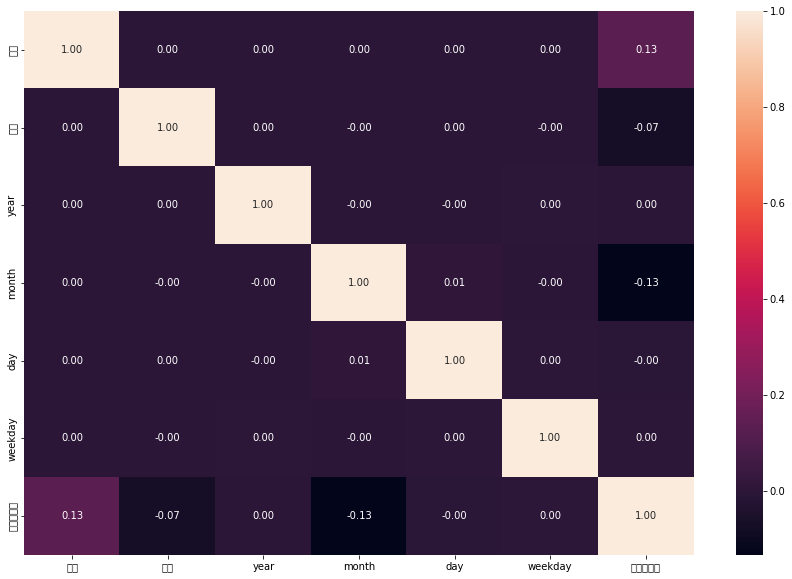

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))     
sns.heatmap(train_x.corr(), annot=True, fmt=".2f")
plt.show()

In [ ]:
 ,# a_company_13["공급량"] + a_company_14.reset_index(drop=True)["공급량"] + a_company_15.reset_index(drop=True)["공급량"] + a_company_15.reset_index(drop=True)["공급량"] +

# 학습

# 로그
로그를 취함

In [ ]:
y_train_log = np.log1p(train_y)
y_val_log = np.log1p(val_y)

# One hot encoding

In [ ]:
ohe = OneHotEncoder()
ohen=pd.DataFrame(ohe.fit_transform(train_test_x[["day","구분","시간"]]).toarray())
ohen

NameError: ignored

In [ ]:
cat_x=pd.concat(((train_test_x[["month","weekday"]]),(ohen)),axis=1)

# 모델 선정 및 Parameter setting

In [ ]:
d_train = lgb.Dataset(train_x, y_train_log)
d_val = lgb.Dataset(val_x, y_val_log)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

lgb_model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, 
                      early_stopping_rounds=10
                      )
#10.07나왔음

Training until validation scores don't improve for 10 rounds.
[20]	valid_0's l1: 0.235905
[40]	valid_0's l1: 0.190712
Early stopping, best iteration is:
[47]	valid_0's l1: 0.190195


# 추론 및 결과 제출

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/포트폴리오/데이콘_가스 공급량수요예측/csv_data/sample_submission.csv')

In [ ]:
test_data.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [ ]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [ ]:
test_data['일자'] = test_data['일자|시간|구분'].str.split(' ').str[0]
test_data['시간'] = test_data['일자|시간|구분'].str.split(' ').str[1].astype(int)
test_data['구분'] = test_data['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test_data['일자'] = pd.to_datetime(test_data['일자'])
test_data['year'] = test_data['일자'].dt.year
test_data['month'] = test_data['일자'].dt.month
test_data['day'] = test_data['일자'].dt.day
test_data['weekday'] = test_data['일자'].dt.weekday

In [ ]:
test_data['구분'] = test_data['구분'].map(d_map)

In [ ]:
test_data=test_data.merge(company_mean,how="left",on=["구분","month","day","시간"])

In [ ]:
test_data = test_data[features]

In [ ]:
test_data

,시간,구분,month,day,평균공급량
0,1,0,1,1,1913.798167
1,2,0,1,1,1801.091833
2,3,0,1,1,1696.859000
3,4,0,1,1,1689.182667
4,5,0,1,1,1796.721167
...,...,...,...,...,...
15115,20,6,3,31,316.634333
15116,21,6,3,31,327.582500
15117,22,6,3,31,311.249500
15118,23,6,3,31,277.961667


In [ ]:
# test_data["평균공급량"]=np.log1p(test_data["평균공급량"])

In [ ]:
ohe = OneHotEncoder()
test_oh=pd.DataFrame(ohe.fit_transform(test_data[["day","구분","시간"]]).toarray())
test_oh

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
final =pd.concat(((test_x[["month","weekday"]]),(test_oh)),axis=1)
final

In [ ]:
result = []
for i in models:
    result.append(i.predict(final))
predict = np.mean(result, axis = 0)

In [ ]:
pred=lgb_model.predict(test_data)
pred

array([7.51488349, 7.45597546, 7.39808104, ..., 5.72813374, 5.62991667,
       5.53389306])

In [ ]:
pred=np.expm1(pred)
pred

array([1834.15364324, 1729.17087929, 1631.84804547, ...,  306.39505302,
        277.63889798,  252.12743501])

In [ ]:
# preds = model.predict(test_x)

In [ ]:
submission['공급량'] = pred

In [ ]:
submission.to_csv('baseline.csv', index=False)

In [ ]:
predict=st.predict(final)